# 1. Nr. camere predict Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

from mpl_toolkits.mplot3d.axes3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
raw_data = pd.read_csv('/content/gdrive/MyDrive/IA/Bucharest.csv')
data = torch.tensor(raw_data.to_numpy(), dtype=torch.float32)

In [ ]:
valpunct = data[:,6]/data[:,5]
combined_train = np.vstack((data[:,1], valpunct)).T


combined_train_inp = torch.tensor(combined_train)
combined_train_tar = torch.tensor(data[:,0])

data_mean = torch.mean(combined_train_inp, dim=0)
print(data_mean)

data_var = torch.var(combined_train_inp, dim=0)
print(data_var)


tensor([   69.8125, 52671.5234])
tensor([8.4605e+02, 4.1029e+09])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
combined_train_inp = (combined_train_inp - data_mean)/torch.sqrt(data_var)

train_ds = TensorDataset(combined_train_inp[:3000,:], combined_train_tar[:3000].T)
test_ds = TensorDataset(combined_train_inp[3000:,:], combined_train_tar[3000:].T)

train_dl = DataLoader(train_ds, 4, shuffle = True)
test_dl = DataLoader(test_ds, 4, shuffle = True)

In [ ]:
def plot_data_scatter(features, targets):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:,0], features[:,1], targets, c='r')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$y$')
    return ax

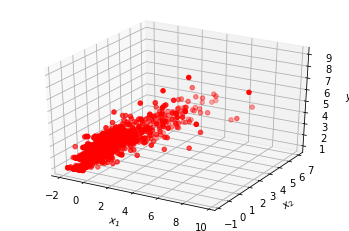

In [ ]:
plot_data_scatter(combined_train_inp,combined_train_tar)

In [ ]:
class LinearRegression(nn.Module):

    def __init__(self, n_features):
        super(LinearRegression, self).__init__()

        self.linear = nn.Linear(in_features=n_features, out_features=1)

    def forward(self, x):

        return self.linear(x)

In [ ]:
model = LinearRegression(2)


opt = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(101):
  for x,y in train_dl:
    scores = model(x)
    loss = criterion(torch.flatten(scores),y)
    opt.zero_grad()
    loss.backward()
    opt.step()
  if(epoch%10==0 & epoch == 0):
    print("Epoch: " + str(epoch))
    print("Loss: " + str(loss))

Epoch: 0
Loss: tensor(0.3194, grad_fn=<MseLossBackward>)
Epoch: 10
Loss: tensor(0.2948, grad_fn=<MseLossBackward>)
Epoch: 20
Loss: tensor(0.0816, grad_fn=<MseLossBackward>)
Epoch: 30
Loss: tensor(0.6241, grad_fn=<MseLossBackward>)
Epoch: 40
Loss: tensor(0.0956, grad_fn=<MseLossBackward>)
Epoch: 50
Loss: tensor(0.1380, grad_fn=<MseLossBackward>)
Epoch: 60
Loss: tensor(0.1775, grad_fn=<MseLossBackward>)
Epoch: 70
Loss: tensor(0.2085, grad_fn=<MseLossBackward>)
Epoch: 80
Loss: tensor(0.4347, grad_fn=<MseLossBackward>)
Epoch: 90
Loss: tensor(0.1333, grad_fn=<MseLossBackward>)
Epoch: 100
Loss: tensor(0.0766, grad_fn=<MseLossBackward>)


In [ ]:
regression_pred = []
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  avg_miss = 0
  model.eval()

  with torch.no_grad():
    for  x, y in loader:
      scores= model(x)
      predictions = torch.round(scores)

      i = 0;
      for tens in predictions:
        if (tens == y[i]):
          num_correct+=1
        else:
          diff = tens-y[i]
          diff = abs(diff)
          avg_miss+=diff
        i+=1
        regression_pred.append(tens)
      num_samples += predictions.size(0)
  print(num_correct)
  print( num_samples-num_correct)
  print(num_correct/num_samples)
  print("Average miss by: " + str(avg_miss/(num_samples-num_correct)))
  model.train()

In [ ]:
regression_pred = []
check_accuracy(test_dl, model)
regression_pred = torch.tensor(regression_pred)

353
176
0.667296786389414
Average miss by: tensor([1.0057])


# 2. Nr. camere predict Classification

In [ ]:
train_input = torch.tensor(data[:,1:7])
train_target = torch.tensor(data[:,0])

train_mean = torch.mean(train_input, dim=0)

train_var = torch.var(train_input, dim=0)

train_input = (train_input - train_mean)/torch.sqrt(train_var)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
train_dataset = TensorDataset(train_input[:3000,:], train_target[:3000].T)
test_dataset = TensorDataset(train_input[3000:,:], train_target[3000:].T)

train_loader = DataLoader(train_dataset, 2)
test_loader = DataLoader(test_dataset, 2)

In [ ]:
class MultiLayer(nn.Module):
  def __init__(self, 
               input_size: int, 
               hidden_size: int, 
               output_size: int, 
               hidden_activation_fn = nn.Tanh(),
               output_activation_fn = nn.Softmax(dim=-1)):
      super().__init__()

      self._fst_linear = nn.Linear(
          in_features=input_size,
          out_features=hidden_size,
          bias=True
      )
      
      self._snd_linear = nn.Linear(
          in_features=hidden_size,
          out_features=output_size,
          bias=True
      )

      self._hidden_activation_fn = hidden_activation_fn
      self._output_activation_fn = output_activation_fn
      
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      h = self._fst_linear(x)
      h = self._hidden_activation_fn(h)

      o = self._snd_linear(h)
      o = self._output_activation_fn(o)
      
      return o

In [ ]:
def NLL(output: torch.Tensor, true_labels: torch.Tensor) -> torch.Tensor:
    likelihood = output.gather(1, true_labels.view(-1,1))

    loss = -torch.log(likelihood)
    loss = torch.mean(loss)

    return loss

In [ ]:
class GD:
  def __init__(self, params: torch.Tensor, lr: int):
    self.w1, self.w2, self.b1, self.b2 = list(params)
    self.lr = lr

  def step(self):
    with torch.no_grad():
      self.w1 -= self.lr * self.w1.grad
      self.b1 -= self.lr * self.b1.grad
      self.w2 -= self.lr * self.w2.grad
      self.b2 -= self.lr * self.b2.grad

In [ ]:
modelClass = MultiLayer(input_size=6, 
                   hidden_size=30,
                   output_size=10)

PRINT_EVERY = 20

train_loss = []

optim = GD(modelClass.parameters(), lr=0.1)

for epoch in range(101):
  for  x, y in train_loader:
    output = modelClass(x)
    y = torch.tensor(y,dtype=torch.int64)

    loss = NLL(output, y)
    loss.backward()
    optim.step()
    modelClass.zero_grad()
  if(epoch%10==0):
    print("Epoch: " + str(epoch))
    print("Loss: " + str(loss))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 0
Loss: tensor(0.7193, grad_fn=<MeanBackward0>)
Epoch: 10
Loss: tensor(0.9246, grad_fn=<MeanBackward0>)
Epoch: 20
Loss: tensor(1.1176, grad_fn=<MeanBackward0>)
Epoch: 30
Loss: tensor(1.0135, grad_fn=<MeanBackward0>)
Epoch: 40
Loss: tensor(0.9672, grad_fn=<MeanBackward0>)
Epoch: 50
Loss: tensor(1.1714, grad_fn=<MeanBackward0>)
Epoch: 60
Loss: tensor(1.2717, grad_fn=<MeanBackward0>)
Epoch: 70
Loss: tensor(1.2457, grad_fn=<MeanBackward0>)
Epoch: 80
Loss: tensor(1.0572, grad_fn=<MeanBackward0>)
Epoch: 90
Loss: tensor(0.7900, grad_fn=<MeanBackward0>)
Epoch: 100
Loss: tensor(0.6730, grad_fn=<MeanBackward0>)


In [ ]:
classifier_pred = []
def check_accuracy_classifier(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for  x, y in loader:
      scores= model(x)
      _, predictions = scores.max(1)

      for tens in predictions:
        classifier_pred.append(tens)

      num_correct += (predictions == y).sum()
      num_samples+=predictions.size(0)
  
  print(num_correct)
  print(num_samples-num_correct)
  print(num_correct/num_samples)
  model.train()
  

In [ ]:
classifier_pred = []
check_accuracy_classifier(test_loader, modelClass)
classifier_pred = torch.tensor(classifier_pred)

tensor(371)
tensor(158)
tensor(0.7013)


# Confusion Matrix for the two approaches

Confusion matrix for classifier approach

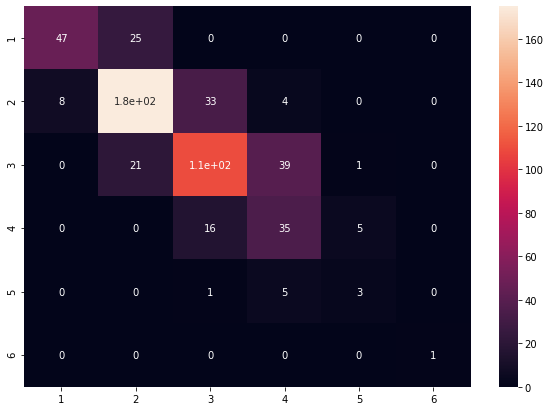

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix(train_target[3000:],classifier_pred)

df_cm = pd.DataFrame(confusion_matrix(train_target[3000:],classifier_pred), index = [i for i in "123456"],
                  columns = [i for i in "123456"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Confusion matrix for regression approach

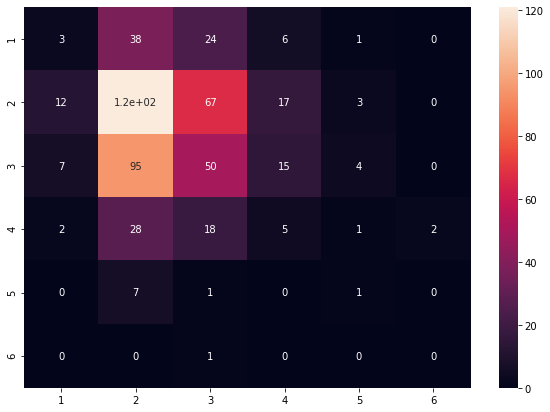

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix(combined_train_tar[3000:],regression_pred)

df_cm = pd.DataFrame(confusion_matrix(combined_train_tar[3000:],regression_pred), index = [i for i in "123456"],
                  columns = [i for i in "123456"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Price regression

In [ ]:
price_train = np.vstack((data[:,0], data[:,1], data[:,5])).T

price_train = torch.tensor(price_train)

price_mean = torch.mean(price_train, dim=0)

price_var = torch.var(price_train, dim=0)

price_train = (price_train - price_mean)/torch.sqrt(price_var)

In [ ]:
train_price_ds = TensorDataset(price_train[:3000,:], data[:3000,6])
test_price_ds = TensorDataset(price_train[3000:,:], data[3000:,6])

train_price_dl = DataLoader(train_price_ds, 32)
test_price_dl = DataLoader(test_price_ds, 32)

In [ ]:
class LinearRegression(nn.Module):

    def __init__(self, n_features):
        super(LinearRegression, self).__init__()

        self.linear = nn.Linear(in_features=n_features, out_features=1)

    def forward(self, x):

        return self.linear(x)

In [ ]:
modelPrice = LinearRegression(3)

opt = torch.optim.SGD(modelPrice.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [ ]:
epoch_num = 401
trainLOSS = []
for epoch in range(epoch_num):
  for x,y in train_price_dl:
    estim = modelPrice(x)
    

    loss = criterion(torch.flatten(estim),y)
    opt.zero_grad()
    loss.backward()
    opt.step()
  if(epoch%5==0 & epoch == 0):
    trainLOSS.append(loss.item())

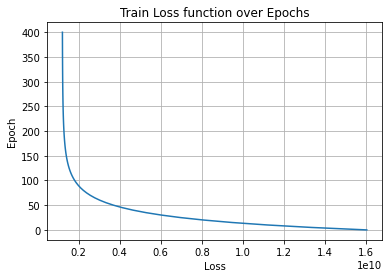

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(trainLOSS), np.arange(0,epoch_num,5))
ax.set(xlabel='Loss', ylabel='Epoch',
       title='Train Loss function over Epochs')
ax.grid()
plt.show()

In [ ]:
valLOSS = []
def loss_validation(loader, model):
  model.eval()
  with torch.no_grad():
    for  x, y in loader:
      estim= model(x)
      loss = criterion(torch.flatten(estim),y)
      valLOSS.append(loss.item())
  model.train()

In [ ]:
loss_validation(test_price_dl,modelPrice)
fig, ax = plt.subplots()
ax.plot(np.array(valLOSS), np.arange(0,np.array(valLOSS).size,1))
ax.set(xlabel='Loss', ylabel='Epoch',
       title='Train Loss function over Epochs')
ax.grid()
plt.show()